# RTSM Project - 2 : Time Series Analysis

### Flow of the Analysis : 

1. Loading all the required Libraries
2. Loading the data
3. Sanitization of the data
4. Forecasting using Simple Moving Average
5. Forecasting using Exponentially Weighted Moving Average (EWMA)
6. Forecasting with Time-Series Data (Univariate) : ARIMA | GARCH

### 1. Loading all the required Libraries

In [40]:
library(quantmod)
library(car)
library(forecast)
library(tseries)
library(FinTS)
library(rugarch)

### 2. Loading the data

In [2]:
# Fetch data for S&P 500 index from Yahoo Finance
getSymbols(Symbols = '^GSPC', 
           src = 'yahoo', 
           from = as.Date('2015-01-01'), 
           to = as.Date('2023-12-31'),
           periodicity = 'daily')

[1] "GSPC"

### 3. Sanitization of the data

In [3]:
# Extract Adjusted Closing Price and remove missing values
stock_price = na.omit(GSPC$GSPC.Adjusted)

In [4]:
# Check the class of sp500_price
class(stock_price)

[1] "xts" "zoo"

In [5]:
#Viewing the sample data how it looks like
View(stock_price)

           GSPC.Adjusted
2015-01-02       2058.20
2015-01-05       2020.58
2015-01-06       2002.61
2015-01-07       2025.90
2015-01-08       2062.14
2015-01-09       2044.81
2015-01-12       2028.26
2015-01-13       2023.03
2015-01-14       2011.27
2015-01-15       1992.67
       ...              
2023-12-15       4719.19
2023-12-18       4740.56
2023-12-19       4768.37
2023-12-20       4698.35
2023-12-21       4746.75
2023-12-22       4754.63
2023-12-26       4774.75
2023-12-27       4781.58
2023-12-28       4783.35
2023-12-29       4769.83

In [6]:
str(stock_price)

An xts object on 2015-01-02 / 2023-12-29 containing: 
  Data:    double [2264, 1]
  Columns: GSPC.Adjusted
  Index:   Date [2264] (TZ: "UTC")
  xts Attributes:
    $ src    : chr "yahoo"
    $ updated: POSIXct[1:1], format: "2024-03-05 19:44:40"


In [7]:
# Confirming if there are any null values in the series
any_null = any(is.null(stock_price))
any_null

[1] FALSE

In [8]:
# Confirming if there are any NA values in the series
any_na = any(is.na(stock_price))
any_na

[1] FALSE

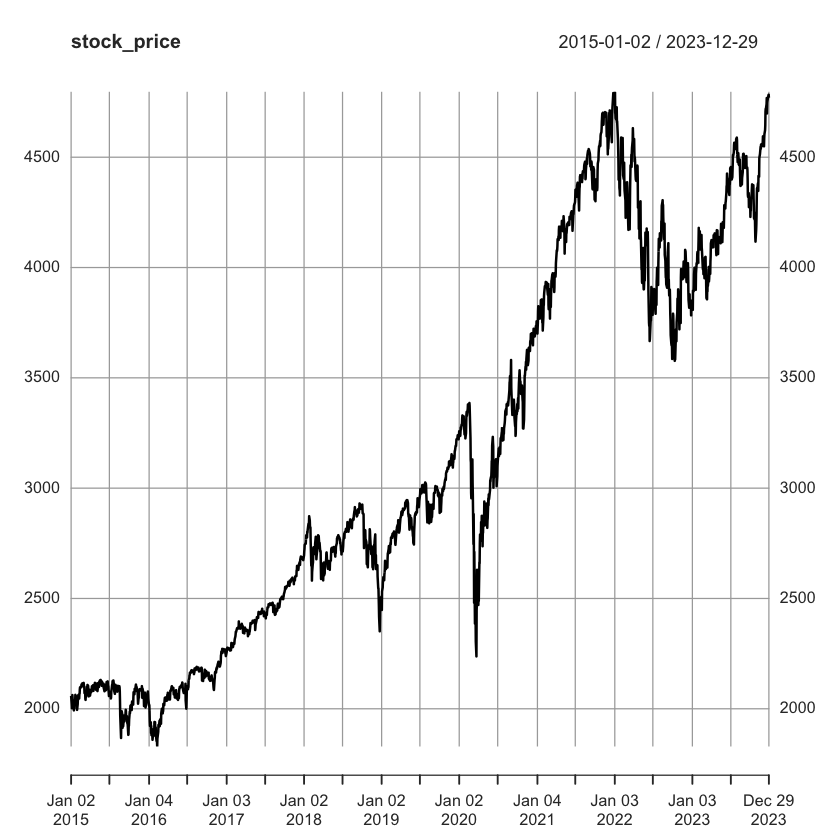

In [9]:
#Visualising the time series data 
plot(stock_price)

### 4. Forecasting using Simple Moving Average (SMA)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,2.007919e-15,36.61735,23.70198,-0.01100454,0.7482536,0.9978547,-0.09672035


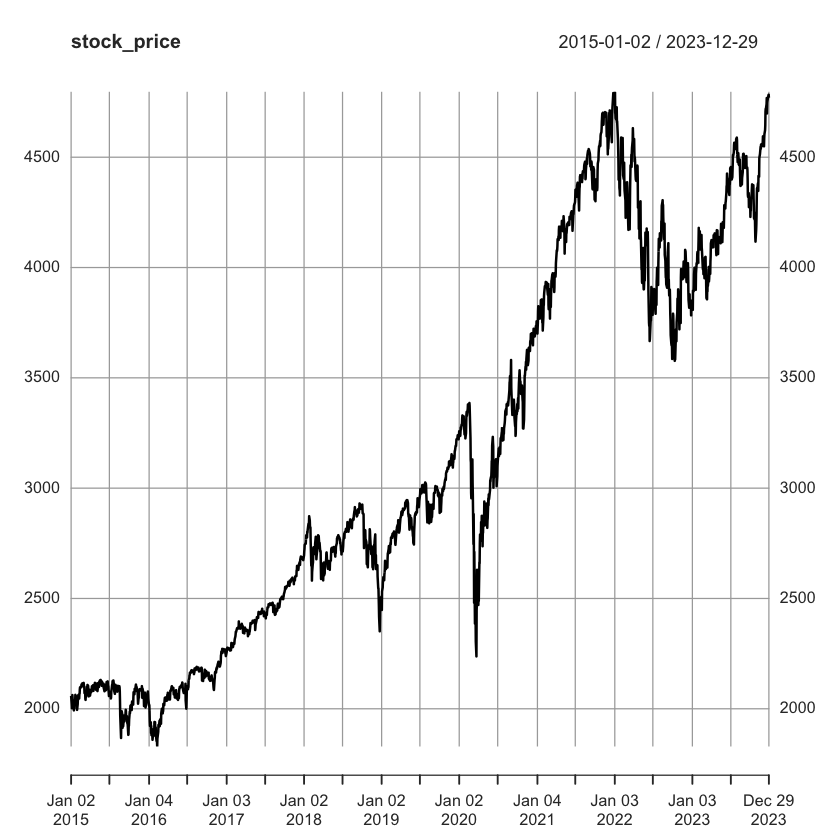

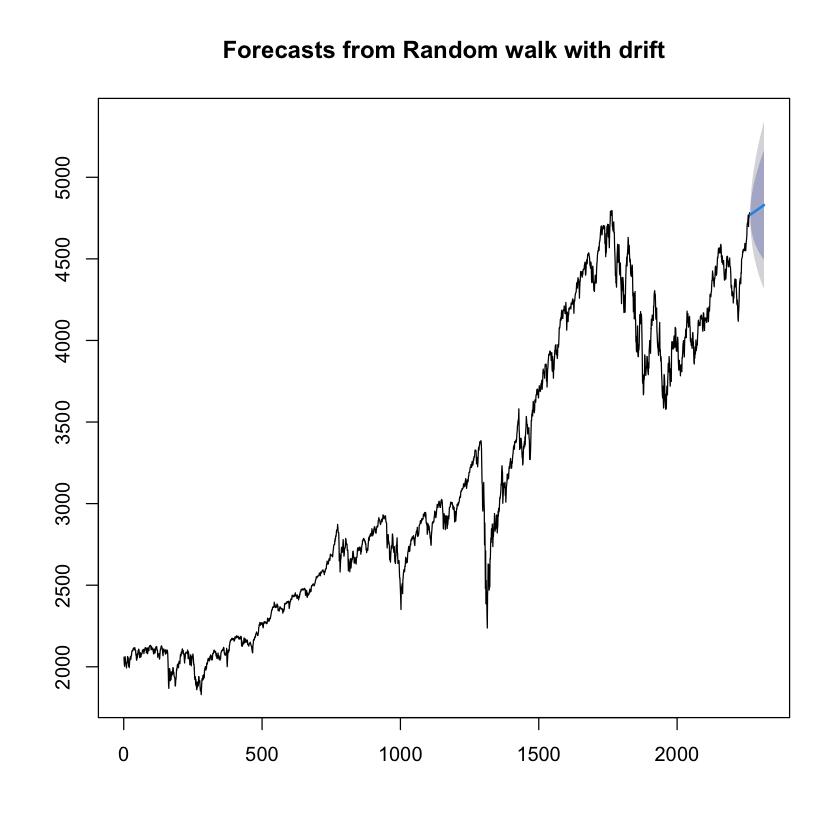

In [10]:
# Simple Moving Average [SMA]

stock_price_ma4 = ma(stock_price, order = 4) 

plot(stock_price, lwd = 2)
lines(stock_price_ma4, col = 'blue', lwd = 20)

# Simple Moving Average : Random Walk (with Drift) Forecast
stock_price_ma8 = rwf(stock_price, h = 50, drift = TRUE) 
accuracy(stock_price_ma8)

plot(stock_price_ma8)

### 5. Forecasting using Exponentially Weighted Moving Average (EWMA)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,2.010767,38.68936,25.98255,0.0523042,0.8138979,1.093867,0.3276863


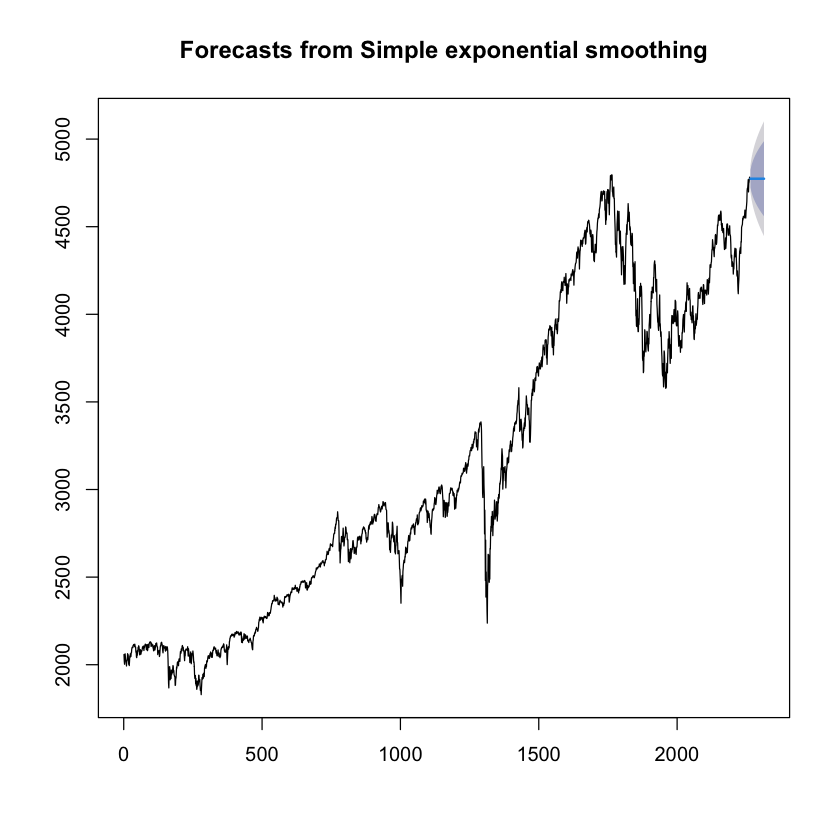

In [11]:
stock_price_es = ses(stock_price, h = 50, alpha = 0.6)
accuracy(stock_price_es)

plot(stock_price_es)

### 6. Forecasting with Time-Series Data (Univariate) : ARIMA | GARCH

#### 6.1 Decomposing Time series data

In [12]:
# Decompose Time-Series Data into Trend | Seasonality | Randomness Components
TSR = decompose(stock_price) # tsr : Trend | Seasonality | Randomness
plot(TSR)

ERROR: Error in decompose(stock_price): time series has no or less than 2 periods


#### 6.2 Checking for Stationarity of the time series data

##### p-value (0.1792) of ADF test is greater that 0.05 hence, we accept the null hypothesis which means the time series data of stock price is not stationary

In [13]:
# Inference : S & P 500 Time-Series is Non-Stationary
# The null hypothesis H0 for the Augmented Dickey-Fuller test is that the time series has a unit root, indicating that it is non-stationary.

adf_test_stock_price = adf.test(stock_price);
adf_test_stock_price 


	Augmented Dickey-Fuller Test

data:  stock_price
Dickey-Fuller = -2.9427, Lag order = 13, p-value = 0.1792
alternative hypothesis: stationary


##### Since the time series data of stock price is not stationary, we take the log difference of the price data to find the returns

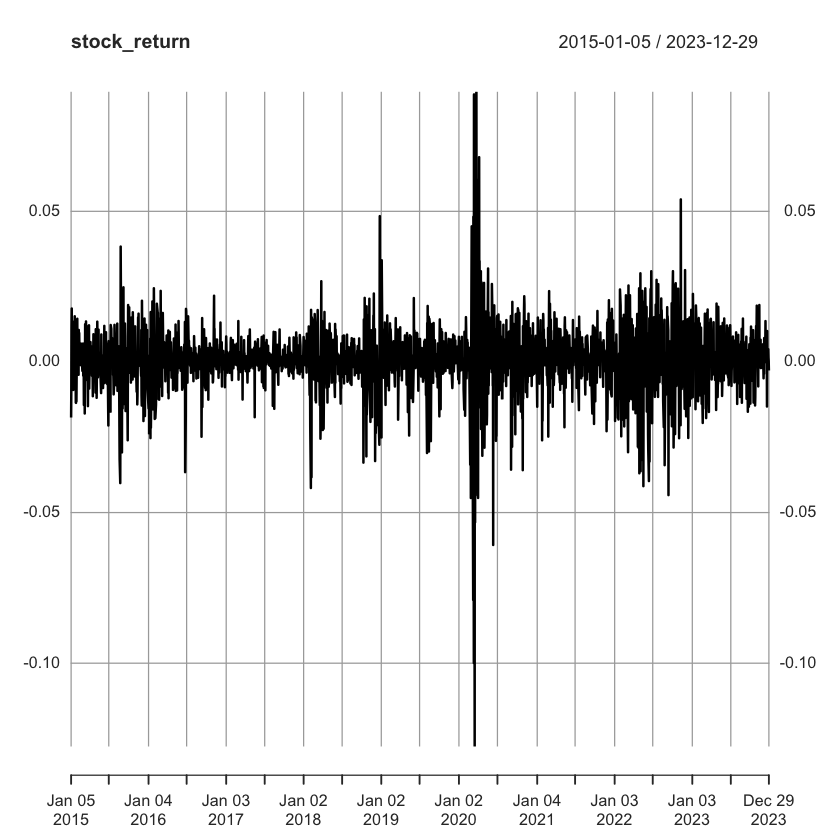

In [14]:
# finding log difference of stock price to determine returns
stock_return = na.omit(diff(log(stock_price)));
plot(stock_return)

#### 6.3 Checking for the stationarity of time series data of returns

##### p-value (0.01) of ADF test is less than 0.05 hence, we fail to accept the null hypothesis which means the time series data of stock returns is stationary

In [15]:
# Inference : S & P 500 Time-Series is Stationary
# The null hypothesis H0 for the Augmented Dickey-Fuller test is that the time series has a unit root, indicating that it is non-stationary.

adf_test_stock_return = adf.test(stock_return);
adf_test_stock_return

Warning message in adf.test(stock_return):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  stock_return
Dickey-Fuller = -12.736, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary


##### Since stock returns are stationary we use returns time series data for analysis

#### 6.4 Check for Auto-Correlation using Ljung-Box Test for Autocorrelation (H0: No Autocorrelation)

##### p-value (7.422e-12) of Ljung-Box test is less than 0.05 hence, we fail to accept the null hypothesis which means the time series data of stock price is Autocorrelated

In [16]:
# Inference : Stock returns Time-Series is Autocorrelated
lb_test_stock_return = Box.test(stock_return);
lb_test_stock_return


	Box-Pierce test

data:  stock_return
X-squared = 46.913, df = 1, p-value = 7.422e-12


#### 6.5 Autocorrelation Function (ACF) | Partial Autocorrelation Function (PACF)

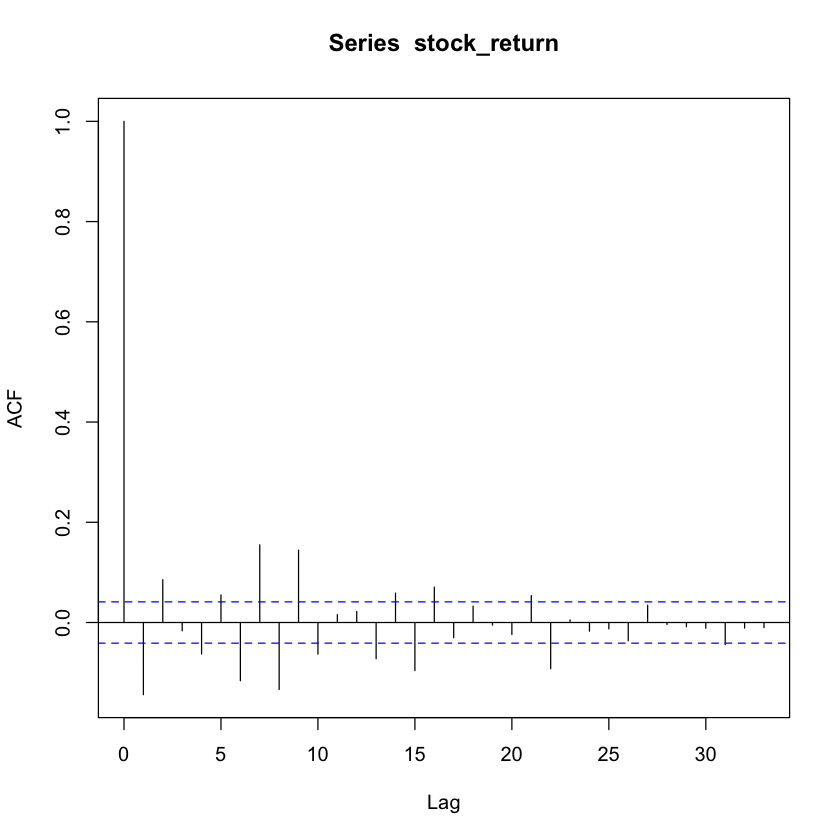

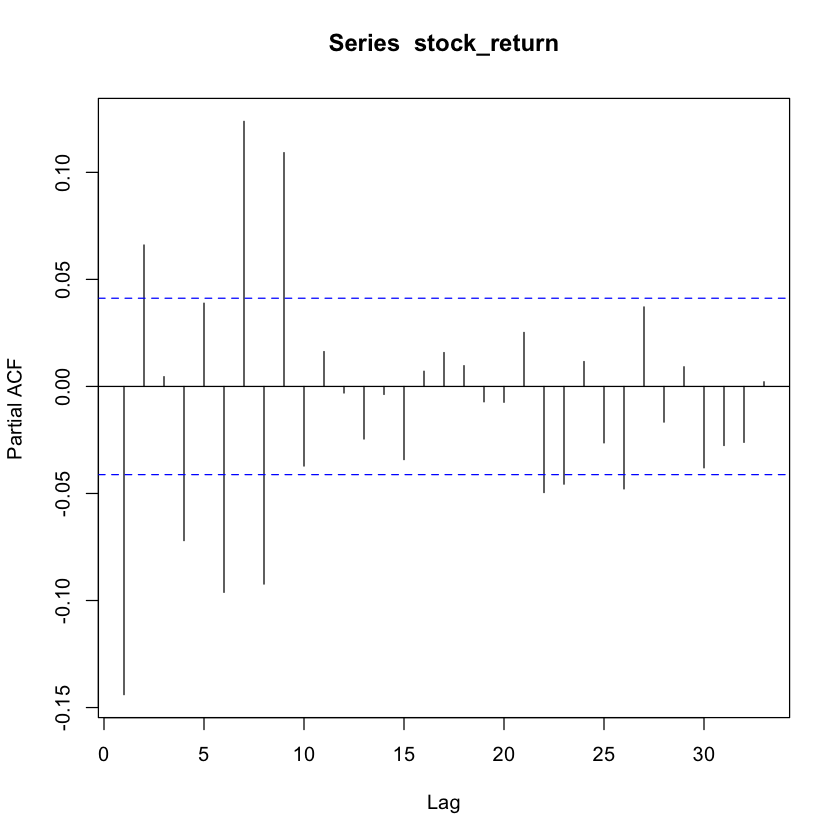

In [17]:
acf(stock_return) # ACF of Stock returns (Stationary) Series
pacf(stock_return) # PACF of Stock returns (Stationary) Series

#### 6.6 ARMA modelling using AR = 1 and MA = 1

In [18]:
# ARIMA (1, 0, 1) or ARMA(1, 1)
arma11 = arima(stock_return, order = c(1, 0, 3));
arma11


Call:
arima(x = stock_return, order = c(1, 0, 3))

Coefficients:
         ar1      ma1     ma2      ma3  intercept
      0.4429  -0.5790  0.1533  -0.0802      4e-04
s.e.  0.2727   0.2726  0.0433   0.0280      2e-04

sigma^2 estimated as 0.0001304:  log likelihood = 6910.41,  aic = -13808.83

#### 6.7 ARMA modelling using AR = 1 and MA = 7

In [19]:
# ARIMA (1, 0, 7) or ARMA(1, 7)
arma17 = arima(stock_return, order = c(1, 0, 7));
arma17


Call:
arima(x = stock_return, order = c(1, 0, 7))

Coefficients:
          ar1     ma1      ma2     ma3      ma4      ma5      ma6     ma7
      -0.6283  0.5297  -0.0141  0.0326  -0.0636  -0.0052  -0.0570  0.0795
s.e.   0.0604  0.0623   0.0238  0.0240   0.0244   0.0236   0.0239  0.0239
      intercept
          4e-04
s.e.      2e-04

sigma^2 estimated as 0.0001258:  log likelihood = 6950.97,  aic = -13881.93

#### 6.8 ARMA modelling using AR = 1 and MA = 8

In [20]:
# ARIMA (1, 0, 8) or ARMA(1, 8)
arma18 = arima(stock_return, order = c(1, 0, 8));
arma18


Call:
arima(x = stock_return, order = c(1, 0, 8))

Coefficients:
          ar1     ma1     ma2     ma3      ma4      ma5      ma6     ma7
      -0.5579  0.4613  -0.003  0.0302  -0.0615  -0.0021  -0.0613  0.0667
s.e.   0.0775  0.0783   0.024  0.0233   0.0230   0.0233   0.0235  0.0248
          ma8  intercept
      -0.0466      4e-04
s.e.   0.0253      2e-04

sigma^2 estimated as 0.0001256:  log likelihood = 6952.55,  aic = -13883.1

#### 6.9 Auto ARIMA modelling

In [21]:
arma_pq_stock_return = auto.arima(stock_return); 
arma_pq_stock_return

Series: stock_return 
ARIMA(4,0,4) with non-zero mean 

Coefficients:
          ar1     ar2      ar3      ar4     ma1      ma2     ma3     ma4   mean
      -0.2440  0.7599  -0.3591  -0.8368  0.1542  -0.7268  0.4316  0.6939  4e-04
s.e.   0.0361  0.0359   0.0413   0.0373  0.0454   0.0429  0.0493  0.0460  2e-04

sigma^2 = 0.0001244:  log likelihood = 6967.94
AIC=-13915.88   AICc=-13915.79   BIC=-13858.64

#### 6.10 Determining Residuals using forecasted values of Auto ARIMA model

In [22]:
Residuals = arma_pq_stock_return$residuals
head(Residuals)

A Time Series:
[1] -0.018073312 -0.011589532  0.011123059  0.018883693 -0.008891514
[6] -0.009998985

In [23]:
length(Residuals)

[1] 2263

In [24]:
length(stock_return)

[1] 2263

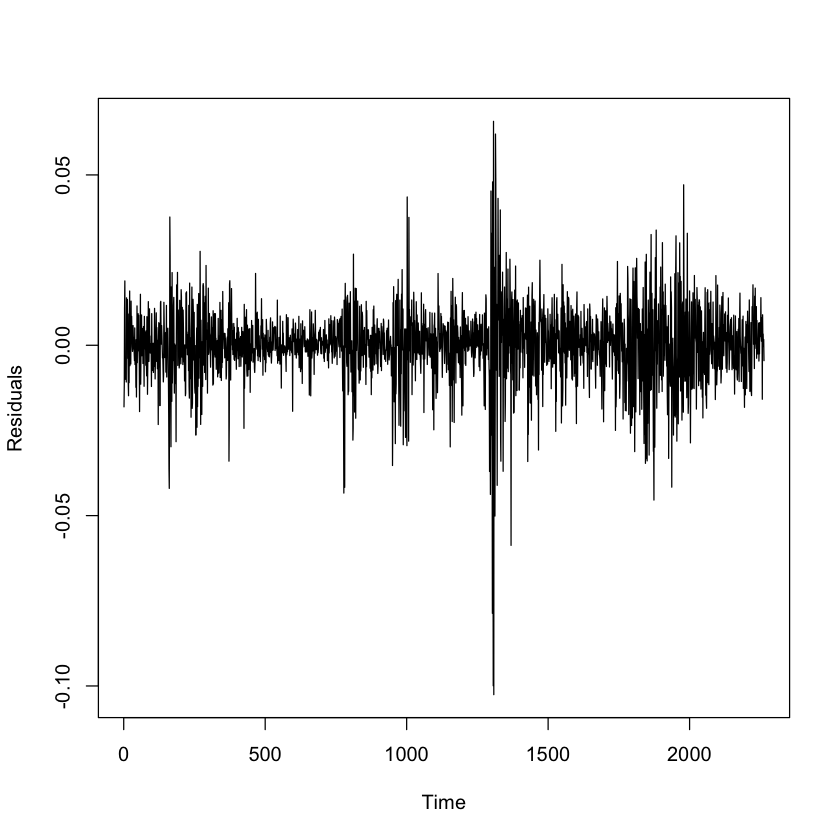

In [84]:
plot(Residuals)

#### 6.11 Ljung box test for residuals (H0: No Autocorrelation)

##### Since p-value(0.8392) is greater than 0.05, we accept the null hypothesis and hence there is no autocorrelation between the residuals and it can inferred that ARIMA model is capturing all the information in the data

In [26]:
lb_test_arma_pq_stock_return = Box.test(Residuals);
lb_test_arma_pq_stock_return


	Box-Pierce test

data:  Residuals
X-squared = 0.041165, df = 1, p-value = 0.8392


#### 6.12 Since the Residuals have no auto-correlation the ARIMA model is appropriate and We do forecasting using ARIMA model

     Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
2264  -0.0022931227 -0.01658518 0.01199893 -0.02415093 0.01956469
2265   0.0014163993 -0.01293319 0.01576599 -0.02052940 0.02336220
2266  -0.0015585713 -0.01592966 0.01281252 -0.02353726 0.02042011
2267   0.0021076678 -0.01226402 0.01647935 -0.01987193 0.02408726
2268   0.0003035911 -0.01409959 0.01470678 -0.02172418 0.02233136
2269   0.0014941122 -0.01293874 0.01592696 -0.02057903 0.02356725
2270   0.0010054228 -0.01351147 0.01552231 -0.02119624 0.02320709
2271  -0.0003905744 -0.01498837 0.01420722 -0.02271598 0.02193483
2272   0.0006608017 -0.01397802 0.01529963 -0.02172735 0.02304895
2273  -0.0014772416 -0.01616680 0.01321231 -0.02394298 0.02098849
2274   0.0007536941 -0.01394067 0.01544806 -0.02171940 0.02322679
2275  -0.0006248279 -0.01531975 0.01407009 -0.02309877 0.02184911
2276   0.0012948843 -0.01340092 0.01599069 -0.02118041 0.02377018
2277   0.0007667585 -0.01395236 0.01548588 -0.02174419 0.02327771
2278   0.0

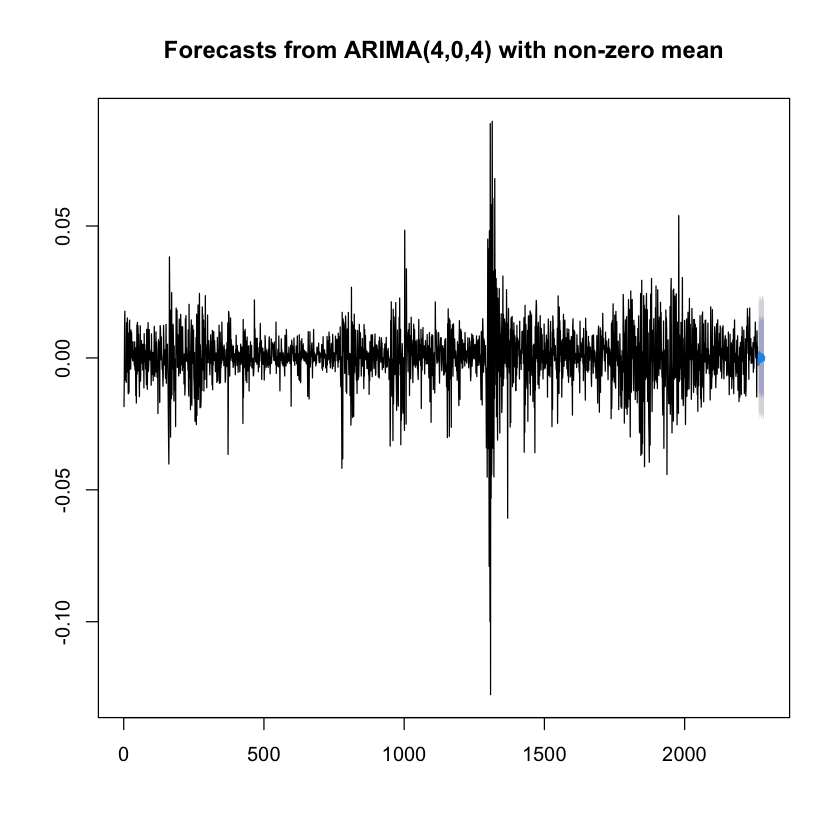

In [27]:
stock_return_fpq_20 = forecast(arma_pq_stock_return, h = 20)
View(stock_return_fpq_20)
plot(stock_return_fpq_20)

     Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
2264  -0.0022931227 -0.01658518 0.01199893 -0.02415093 0.01956469
2265   0.0014163993 -0.01293319 0.01576599 -0.02052940 0.02336220
2266  -0.0015585713 -0.01592966 0.01281252 -0.02353726 0.02042011
2267   0.0021076678 -0.01226402 0.01647935 -0.01987193 0.02408726
2268   0.0003035911 -0.01409959 0.01470678 -0.02172418 0.02233136
2269   0.0014941122 -0.01293874 0.01592696 -0.02057903 0.02356725
2270   0.0010054228 -0.01351147 0.01552231 -0.02119624 0.02320709
2271  -0.0003905744 -0.01498837 0.01420722 -0.02271598 0.02193483
2272   0.0006608017 -0.01397802 0.01529963 -0.02172735 0.02304895
2273  -0.0014772416 -0.01616680 0.01321231 -0.02394298 0.02098849
2274   0.0007536941 -0.01394067 0.01544806 -0.02171940 0.02322679
2275  -0.0006248279 -0.01531975 0.01407009 -0.02309877 0.02184911
2276   0.0012948843 -0.01340092 0.01599069 -0.02118041 0.02377018
2277   0.0007667585 -0.01395236 0.01548588 -0.02174419 0.02327771
2278   0.0

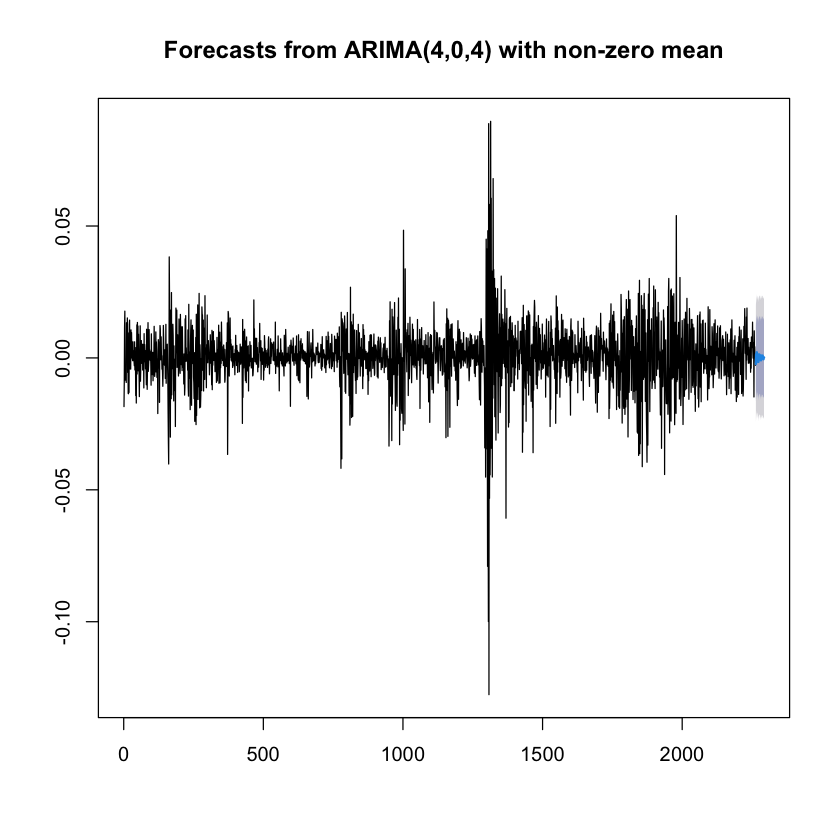

In [28]:
stock_return_fpq_30 = forecast(arma_pq_stock_return, h = 30)
View(stock_return_fpq_30)
plot(stock_return_fpq_30)

     Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
2264  -2.293123e-03 -0.01658518 0.01199893 -0.02415093 0.01956469
2265   1.416399e-03 -0.01293319 0.01576599 -0.02052940 0.02336220
2266  -1.558571e-03 -0.01592966 0.01281252 -0.02353726 0.02042011
2267   2.107668e-03 -0.01226402 0.01647935 -0.01987193 0.02408726
2268   3.035911e-04 -0.01409959 0.01470678 -0.02172418 0.02233136
2269   1.494112e-03 -0.01293874 0.01592696 -0.02057903 0.02356725
2270   1.005423e-03 -0.01351147 0.01552231 -0.02119624 0.02320709
2271  -3.905744e-04 -0.01498837 0.01420722 -0.02271598 0.02193483
2272   6.608017e-04 -0.01397802 0.01529963 -0.02172735 0.02304895
2273  -1.477242e-03 -0.01616680 0.01321231 -0.02394298 0.02098849
2274   7.536941e-04 -0.01394067 0.01544806 -0.02171940 0.02322679
2275  -6.248279e-04 -0.01531975 0.01407009 -0.02309877 0.02184911
2276   1.294884e-03 -0.01340092 0.01599069 -0.02118041 0.02377018
2277   7.667585e-04 -0.01395236 0.01548588 -0.02174419 0.02327771
2278   9.8

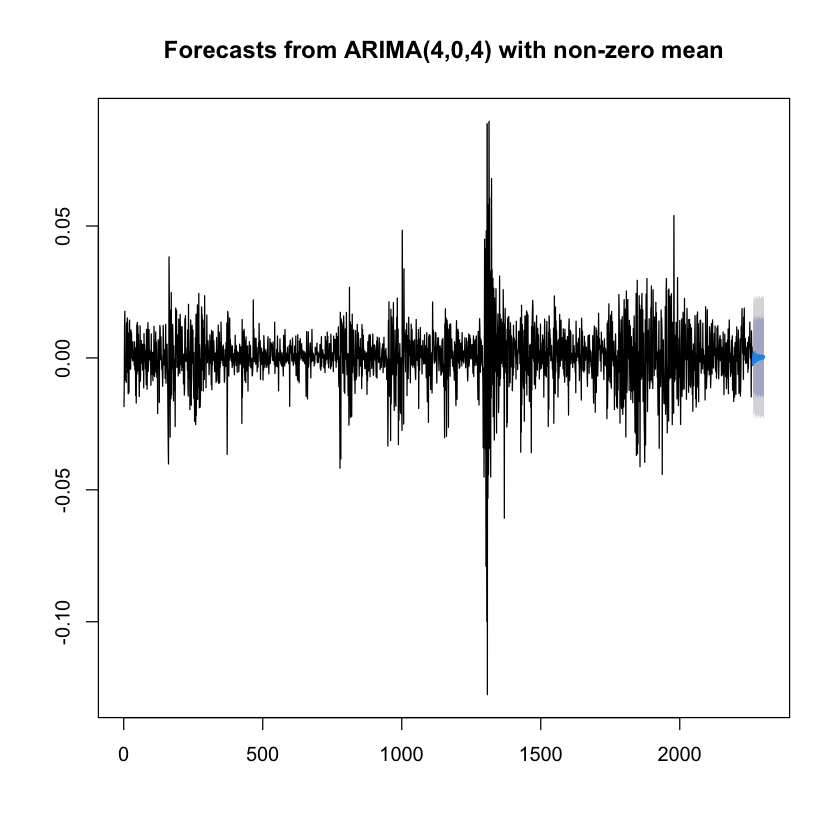

In [29]:
stock_return_fpq_40 = forecast(arma_pq_stock_return, h = 40)
View(stock_return_fpq_40)
plot(stock_return_fpq_40)

     Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
2264  -2.293123e-03 -0.01658518 0.01199893 -0.02415093 0.01956469
2265   1.416399e-03 -0.01293319 0.01576599 -0.02052940 0.02336220
2266  -1.558571e-03 -0.01592966 0.01281252 -0.02353726 0.02042011
2267   2.107668e-03 -0.01226402 0.01647935 -0.01987193 0.02408726
2268   3.035911e-04 -0.01409959 0.01470678 -0.02172418 0.02233136
2269   1.494112e-03 -0.01293874 0.01592696 -0.02057903 0.02356725
2270   1.005423e-03 -0.01351147 0.01552231 -0.02119624 0.02320709
2271  -3.905744e-04 -0.01498837 0.01420722 -0.02271598 0.02193483
2272   6.608017e-04 -0.01397802 0.01529963 -0.02172735 0.02304895
2273  -1.477242e-03 -0.01616680 0.01321231 -0.02394298 0.02098849
2274   7.536941e-04 -0.01394067 0.01544806 -0.02171940 0.02322679
2275  -6.248279e-04 -0.01531975 0.01407009 -0.02309877 0.02184911
2276   1.294884e-03 -0.01340092 0.01599069 -0.02118041 0.02377018
2277   7.667585e-04 -0.01395236 0.01548588 -0.02174419 0.02327771
2278   9.8

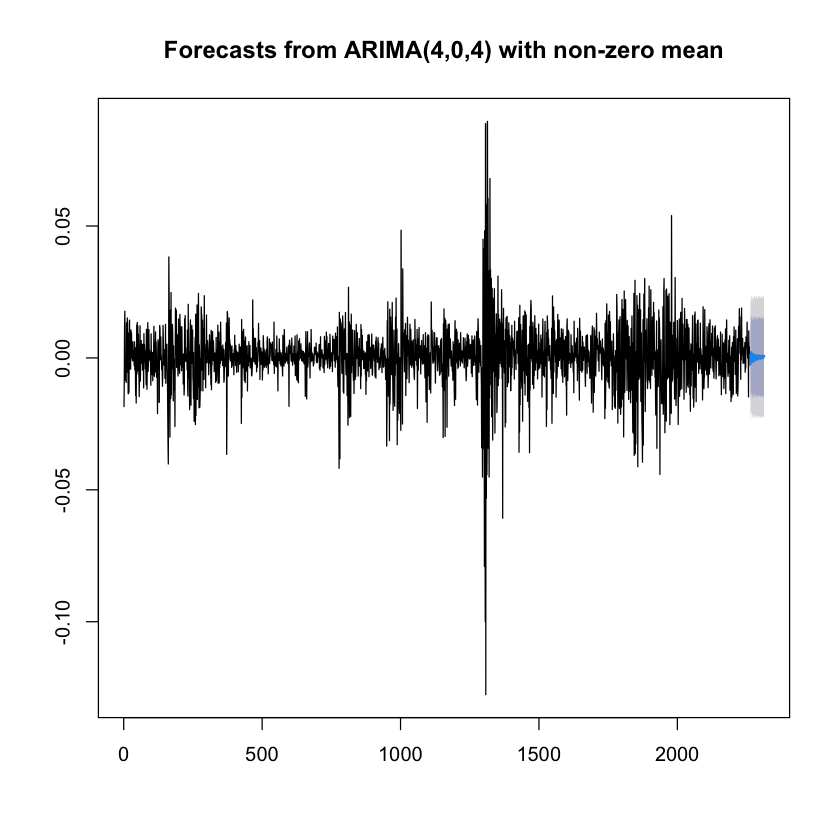

In [30]:
stock_return_fpq_50 = forecast(arma_pq_stock_return, h = 50)
View(stock_return_fpq_50)
plot(stock_return_fpq_50)

#### 6.13 Ljung box test for residuals square (H0: No Autocorrelation)

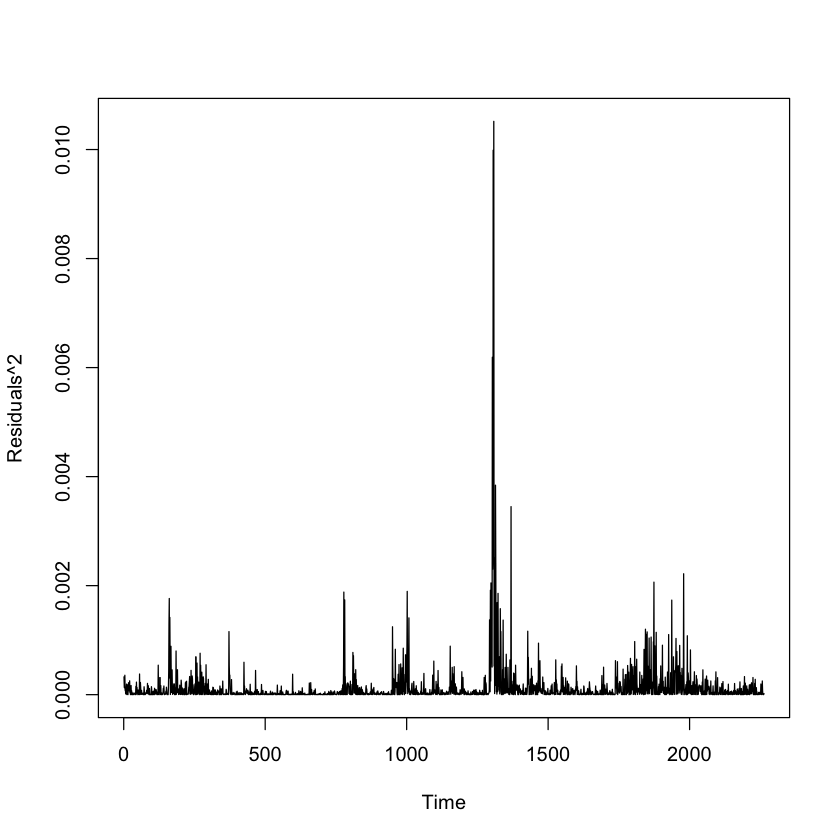

In [31]:
plot(Residuals^2)

In [32]:
length(Residuals^2)

[1] 2263

In [33]:
# Confirming if there are any null values in the series
any_null = any(is.null(Residuals^2))
any_null

[1] FALSE

In [34]:
# Confirming if there are any NA values in the series
any_na = any(is.na(Residuals^2))
any_na

[1] FALSE

##### Since p-value(2.2e-16) is less than 0.05, we fail to accept the null hypothesis and hence there is autocorrelation between the residuals squares

In [35]:
lb_test_arma_pq_stock_return_square = Box.test(Residuals^2);
lb_test_arma_pq_stock_return_square


	Box-Pierce test

data:  Residuals^2
X-squared = 368.31, df = 1, p-value < 2.2e-16


#### Check for heteroscedaticity of :: ARCH LM test for both stock returns series and resdiduals square

#### 6.14 ARCH LM test for residuals square (H0 : No ARCH effect)

##### Since the p-value (2.2e-16) is less than 0.05, we fail to accept the null hypothesis and hence there is ARCH effect in the residual square data

In [36]:
Residual_square_arch_test = ArchTest(Residuals^2, lags = 20)
Residual_square_arch_test


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  Residuals^2
Chi-squared = 848.42, df = 20, p-value < 2.2e-16


#### 6.15 ARCH LM test for stock returns series (H0 : No ARCH effect)

##### Since the p-value (2.2e-16) is less than 0.05, we fail to accept the null hypothesis and hence there is ARCH effect in the stock return series data

In [37]:
stock_return_arch_test = ArchTest(stock_return, lags = 20)
stock_return_arch_test


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  stock_return
Chi-squared = 907.59, df = 20, p-value < 2.2e-16


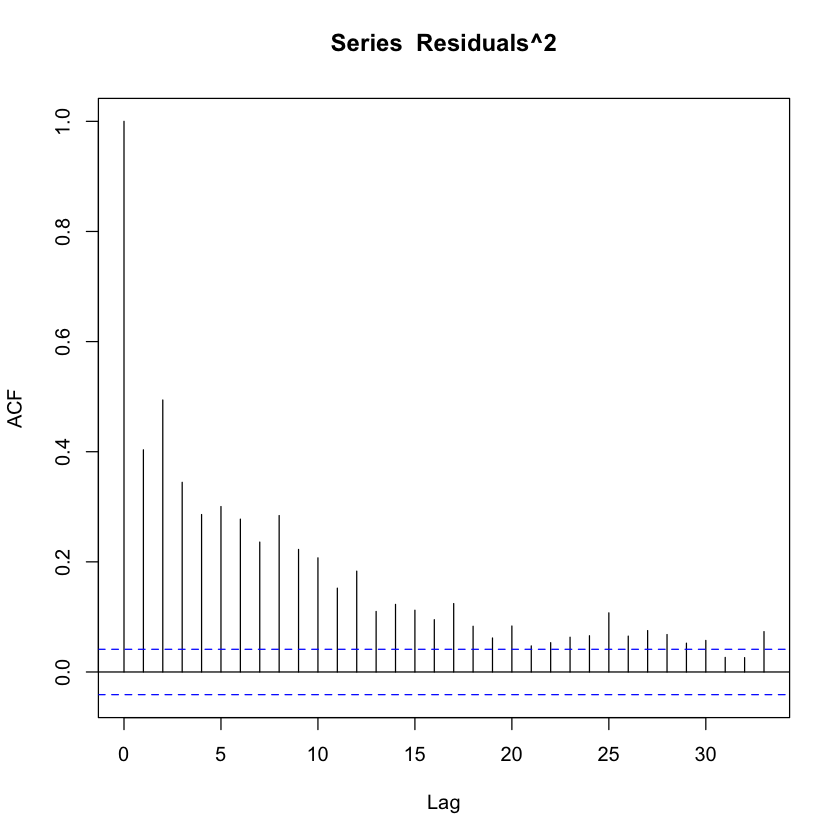

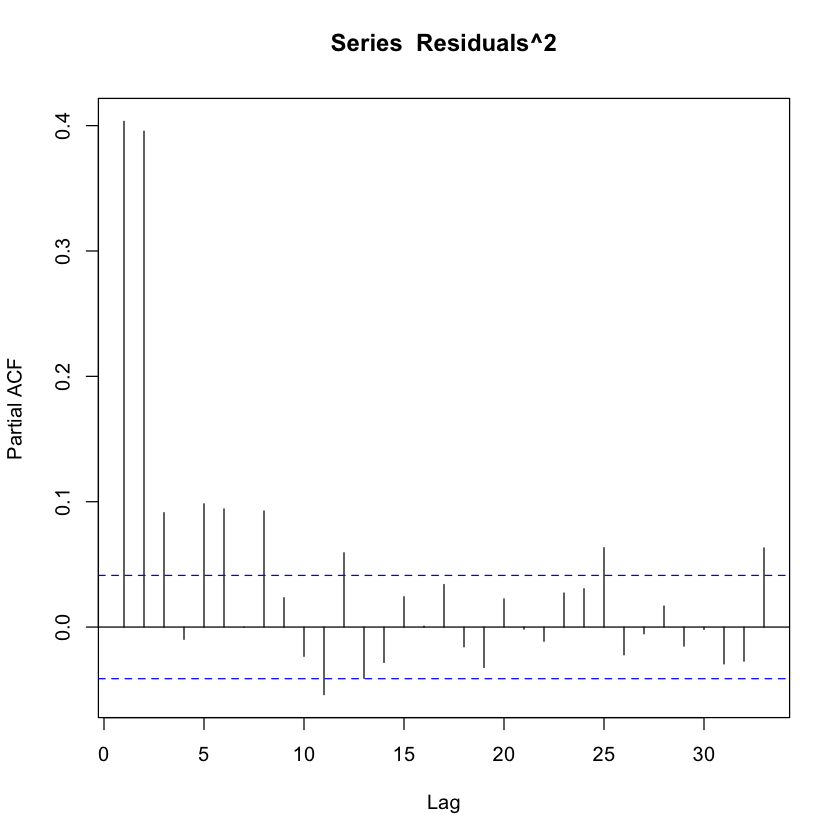

In [138]:
acf(Residuals^2)
pacf(Residuals^2)

#### 6.16 Fitting GARCH (1,1) model on residual sqaures

In [144]:
garch_model1 = ugarchspec(variance.model = list(model = 'sGARCH', garchOrder = c(2,2)), mean.model = list(armaOrder = c(0,0), include.mean = TRUE))
Residuals_square_garch1 = ugarchfit(garch_model1, data = Residuals^2);
Residuals_square_garch1


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(2,2)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000090    0.000003 30.009721  0.00000
omega   0.000000    0.000000  0.001453  0.99884
alpha1  0.025001    0.002042 12.243873  0.00000
alpha2  0.025000    0.001884 13.272667  0.00000
beta1   0.450000    0.030183 14.909284  0.00000
beta2   0.450001    0.021368 21.059166  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000090    0.031515 0.002841  0.99773
omega   0.000000    0.002835 0.000000  1.00000
alpha1  0.025001    1.989429 0.012567  0.98997
alpha2  0.025000   21.550724 0.001160  0.99907
beta1   0.450000  280.902682 0.001602  0.99872
beta2   0.450001  254.365497 0.001769  0.99859



#### 6.17 Checking for Auto-correlation and Heteroscedasticity of GARCH residuals

In [145]:
class(Residuals_square_garch1)

[1] "uGARCHfit"
attr(,"package")
[1] "rugarch"

In [146]:
GARCH_Residuals = residuals(Residuals_square_garch1)
length(GARCH_Residuals)
GARCH_Residuals

[1] 2263

           m.c.seq.row..seq.n...seq.col..drop...FALSE.
0001-01-01                                2.371176e-04
0002-01-01                                4.479024e-05
0003-01-01                                3.419542e-05
0004-01-01                                2.670668e-04
0005-01-01                               -1.046799e-05
0006-01-01                                1.045268e-05
0007-01-01                               -7.576202e-05
0008-01-01                               -6.926911e-05
0009-01-01                                2.668235e-05
0010-01-01                                1.042058e-04
       ...                                            
2254-01-01                               -8.813218e-05
2255-01-01                               -7.319061e-05
2256-01-01                               -2.347811e-05
2257-01-01                                1.613698e-04
2258-01-01                               -9.493919e-06
2259-01-01                               -8.732129e-05
2260-01-01

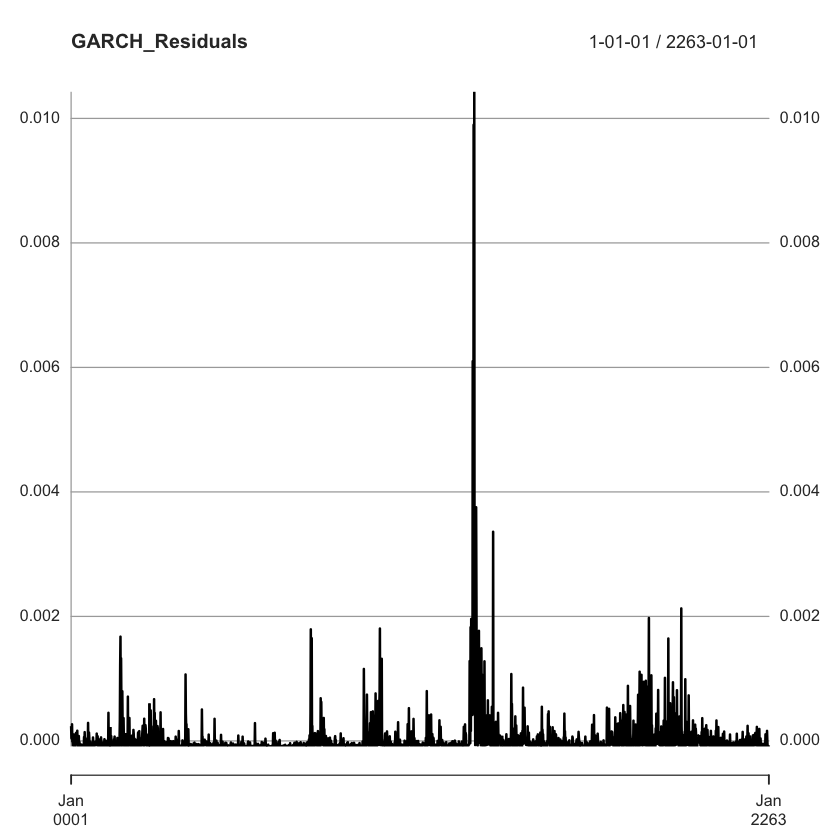

In [147]:
plot(GARCH_Residuals)

In [148]:
GARCH_Residuals_square_arch_test = ArchTest(GARCH_Residuals^2, lags = 20)
GARCH_Residuals_square_arch_test


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  GARCH_Residuals^2
Chi-squared = 901.41, df = 20, p-value < 2.2e-16
